# Emotion Reccognition

In [1]:
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.preprocessing import image
import scipy
import os
import cv2

 ### Dataset

In [2]:
data = pd.read_csv('./icml_face_data.csv')
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [3]:
pixel_data = data[' pixels']
label_data = data['emotion']

### Preprocessing the pixel values

In [4]:
def preprocess_pixels(pixel_data):
    images = []
    for i in range(len(pixel_data)):
        img = np.fromstring(pixel_data[i], dtype='int', sep=' ')
        img = img.reshape(48,48,1)
        images.append(img)
        
    X = np.array(images)
    
    return X

In [5]:
oversampler = RandomOverSampler(sampling_strategy='auto')

X_over, Y_over = oversampler.fit_resample(pixel_data.values.reshape(-1,1), label_data)

X_over_series = pd.Series(X_over.flatten())

In [6]:
X = preprocess_pixels(X_over_series)
Y = Y_over

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, random_state = 45)

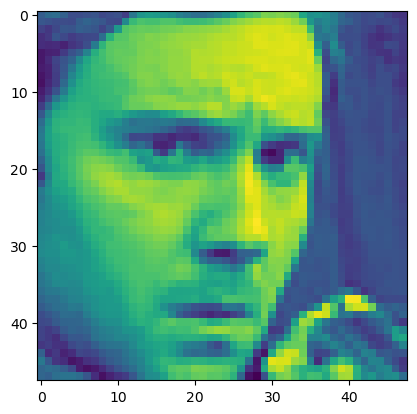

In [7]:
plt.imshow(X[0, :, :,0])

### Defining the Model

In [8]:
def emotion_recognition(input_shape):
    X_input = Input(input_shape)

    X = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)


    X = Conv2D(64, (3,3), strides=(1,1), padding = 'same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((2,2))(X)

    X = Conv2D(64, (3,3), strides=(1,1), padding = 'valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(128, (3,3), strides=(1,1), padding = 'same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)


    X = MaxPooling2D((2,2))(X)

    X = Conv2D(128, (3,3), strides=(1,1), padding = 'valid')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

 

    X = MaxPooling2D((2,2))(X)
    X = Flatten()(X)
    X = Dense(200, activation='relu')(X)
    X = Dropout(0.6)(X)
    X = Dense(7, activation = 'softmax')(X)

    model = Model(inputs=X_input, outputs=X)
    
    return model

In [9]:
model = emotion_recognition((48,48,1))
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

### Training the model

In [10]:

y_train = to_categorical(Y_train, num_classes=7)

y_test = to_categorical(Y_test, num_classes=7)

In [11]:
model.fit(X_train, y_train, epochs = 10, validation_data=(X_test, y_test))

Epoch 1/10
1770/1770 [==============================] - 621s 350ms/step - loss: 1.7273 - accuracy: 0.3233 - val_loss: 1.4521 - val_accuracy: 0.4491
Epoch 2/10
1770/1770 [==============================] - 614s 347ms/step - loss: 1.3976 - accuracy: 0.4646 - val_loss: 1.2018 - val_accuracy: 0.5517
Epoch 3/10
1770/1770 [==============================] - 631s 356ms/step - loss: 1.2165 - accuracy: 0.5304 - val_loss: 1.0892 - val_accuracy: 0.5853
Epoch 4/10
1770/1770 [==============================] - 568s 321ms/step - loss: 1.1046 - accuracy: 0.5742 - val_loss: 1.0294 - val_accuracy: 0.6061
Epoch 5/10
1770/1770 [==============================] - 565s 319ms/step - loss: 1.0170 - accuracy: 0.6110 - val_loss: 1.0134 - val_accuracy: 0.6135
Epoch 6/10
1770/1770 [==============================] - 565s 319ms/step - loss: 0.9406 - accuracy: 0.6415 - val_loss: 0.9114 - val_accuracy: 0.6493
Epoch 7/10
1770/1770 [==============================] - 565s 319ms/step - loss: 0.8708 - accuracy: 0.6702 - val_

### Validating the Model

In [ ]:
preds = model.predict(X_train)
def get_class(preds):
    pred_class = np.zeros((preds.shape[0], 1))
    
    for i in range(len(preds)):
        pred_class[i] = np.argmax(preds[i])
        
    return pred_class

pred_class_train = get_class(preds)

In [ ]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

In [ ]:
img_path = 'test1_happiness.jpeg'
img = image.load_img(img_path, grayscale=True, target_size=(48,48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

prediction = np.argmax(model.predict(x))
print('The predicted emotion is : ' + label_dict[prediction])
my_image = image.load_img(img_path)
plt.imshow(my_image)

### Implementing the model in Real-Time

In [ ]:
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [ ]:

cap = cv2.VideoCapture(0)

while True:
    
    _,cap_image = cap.read()


    cap_img_gray = cv2.cvtColor(cap_image, cv2.COLOR_BGR2GRAY)

    faces = face_haar_cascade.detectMultiScale(cap_img_gray, 1.3, 5)

    for (x,y,w,h) in faces:
        cv2.rectangle(cap_image, (x,y), (x+w,y+h),(255,0,0),2)
        roi_gray = cap_img_gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48,48))
        img_pixels = image.img_to_array(roi_gray)
        img_pixels = np.expand_dims(img_pixels, axis=0)

        predictions = model.predict(img_pixels)
        emotion_label = np.argmax(predictions)

        emotion_prediction = label_dict[emotion_label]

        cv2.putText(cap_image, emotion_prediction, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1 )

        resize_image = cv2.resize(cap_image, (1000,700))
        cv2.imshow('Emotion',resize_image)

        if cv2.waitKey(10) == ord('b'):
            break
    
  
    cap.release()
    cv2.destroyAllWindows